In [1]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\ANJA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [ ]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

<h1 style="color: #ab5bb0; background-color: #ffcccc; padding: 10px; border-radius: 8px;"">Ucitavanje podataka: - STARO</h1>
-bez oversamplinga za disgust klasu, losiji rezultat, ne koristiti

In [3]:
"""
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#train_val_data_dir = r'..\..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear'
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
#test_data_dir = r'..\..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)
"""

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<h1 style="color: #ab5bb0; background-color: #ccffcc; padding: 10px; border-radius: 8px;">Ucitavanje podataka: - NOVO</h1>
-sa oversamplingom za 'Disgust' 

<b>Train i validation set:</b>

In [2]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np
import os
import random

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Parametri
#train_val_data_dir = r'..\..\images\train'
train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128
target_class = 'disgust'
target_count = 4000

# Ucitamo sve slike u memoriju
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinacne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# Razdvojanje slika po klasama
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# Oversampling target klase
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# Spoji sve klase
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Permutacija da batch-evi budu mijesani
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# Stratified split 80/20 po klasama
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Permutacija nakon split-a
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# Kreiranje batch-eva
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [3]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [4]:
print(train_ds.class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<b>Test set:</b>

In [5]:
# test DS
batch_size = 128
#test_data_dir = r'..\..\images\test'
test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<div style="background-color: #cceeff; padding: 10px; border-radius: 8px;">
  <p>Broj slika u originalnom datasetu - bez oversamplinga:</p>
  <ul>
    <li>training 28821</li>
    <li>validation (test kod nas) 7066</li>
  </ul>
</div>


<div style="background-color: #cceeff; padding: 10px; border-radius: 8px;">
  <p>Broj slika u modifikovanom datasetu - sa oversamplingom:</p>
  <ul>
    <li>training 32385</li>
    <li>validation (test kod nas) 7066</li>
  </ul>
</div>


In [6]:
def show_first_images_by_category_grayscale(dataset): 
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

In [7]:
# Metoda koja prikazuje po jednu sliku iz svake kategorije - rgb 
def show_first_images_by_category_rgb(dataset):   
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image) 
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

<h3 style="color: #ab5bb0">Prebrojavanje slika po kategorijama:</h3>

In [8]:
def count_labels(dataset):
    counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
    return counts



print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))


Train dataset: {'angry': 3194, 'disgust': 3200, 'fear': 3282, 'happy': 5731, 'neutral': 3985, 'sad': 3950, 'surprise': 2564}
Validation dataset: {'angry': 799, 'disgust': 800, 'fear': 821, 'happy': 1433, 'neutral': 997, 'sad': 988, 'surprise': 641}
Test dataset: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - nisu jos normalizovane niti konv. u rgb</h3>

In [9]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

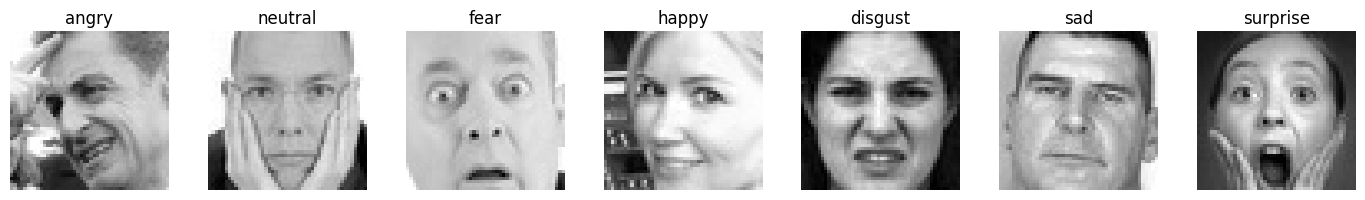

In [10]:
show_first_images_by_category_grayscale(train_ds)

<h3 style="color: #ab5bb0">Normalizacija:</h3>

In [6]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

In [7]:
for x, y in train_ds.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 1)

(128, 48, 48, 1)


Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


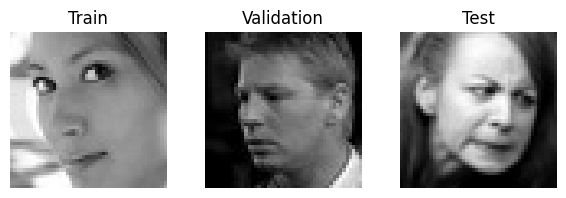

In [13]:
# Metoda koja prikazuje po 1 sliku iz train test i validation skupova
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikaz slika u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)

<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, nisu konv. u rgb</h3>

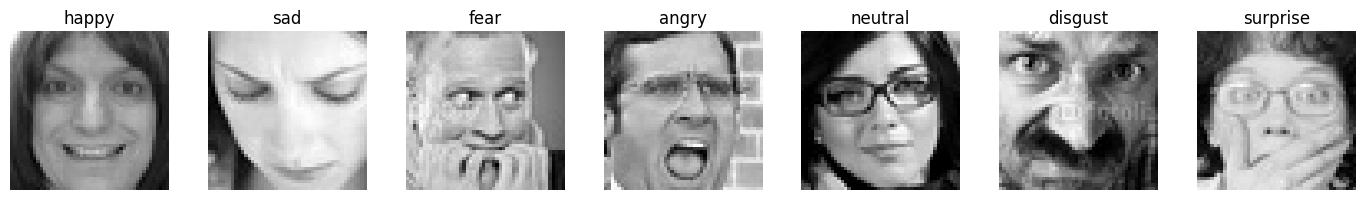

In [14]:
show_first_images_by_category_grayscale(train_ds)

<h3 style="color: #ab5bb0">GRAYSLACE TO RGB:</h3>

In [8]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

for x, y in train_ds_rgb.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 3)


(128, 48, 48, 3)


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, konv. u rgb</h3>

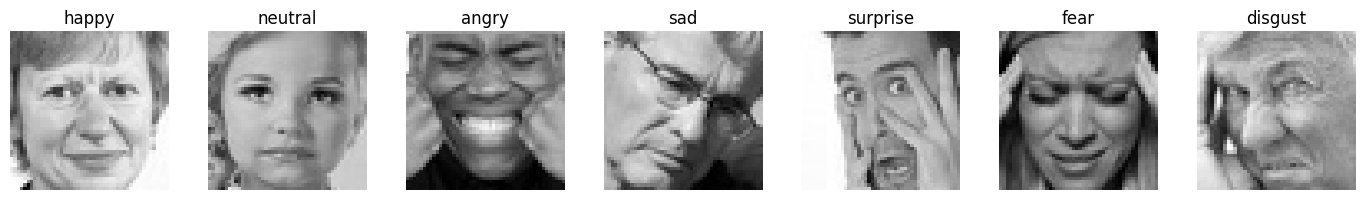

In [17]:
show_first_images_by_category_rgb(train_ds_rgb)

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Metoda koja prikazuje sliku u realnoj velicini (za poredjenje prilikom resize-a)
def show_first_image_real_size(dataset, dpi=100):
    # 1. batch
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break
    
    # 1. slika
    image = images[0]
    
    h, w = image.shape[:2]

    fig_width = w / dpi
    fig_height = h / dpi

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    plt.show()


<h3 style="color: #ab5bb0">RESIZE IMAGES</h3>
-uporedjen bilinear i nearest method, nearest jako istice piksele - blokasto, bilinear prirodniji i cuva dovoljno detalja

In [9]:
def resize_images(x, y, h=128, w=128):
    x = tf.image.resize(x, [h, w], method=tf.image.ResizeMethod.BILINEAR)
    return x, y

<h1 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">VGGNET 19</h1> 
<h4>Prikaz treniranja, vrijednosti izracunatih metrika, prikaz metrika na train i validation skupu, konfuziona matrica</h4>
-model oko 3 puta sporiji od Inception V3 -> manja dimenzija slika u odnosu na Inception V3
<br>
Rezultati nedovoljno dobri, radi toga ce biti radjen fine tuning

In [20]:
train_ds_rgb_1 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))
val_ds_rgb_1   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))
test_ds_rgb_1  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=96, w=96))

In [48]:
for x, y in train_ds_rgb_1.take(1):
    print(x.shape) 

(128, 96, 96, 3)


Dimenzije slike: (48, 48, 3)


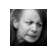

Dimenzije slike: (96, 96, 3)


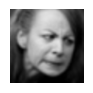

In [49]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_1.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_1)

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametri
img_height = 96
img_width = 96
num_classes = 7
batch_size = 128
learning_rate = 5e-3 #spor model, krecem sa vecom LR
epochs = 80

# Data augmentation - u radu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


# Build VGG19 model
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in vgg_base.layers:
    layer.trainable = False

for i, layer in enumerate(vgg_base.layers):
    print(i, layer.name, layer.__class__.__name__, layer.trainable)


inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.BatchNormalization()(x) #rad
x = layers.Dropout(0.2)(x) #u radu 0.5, ali radi manje neurona stavljam na 0.2
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

0 input_layer_19 InputLayer False
1 block1_conv1 Conv2D False
2 block1_conv2 Conv2D False
3 block1_pool MaxPooling2D False
4 block2_conv1 Conv2D False
5 block2_conv2 Conv2D False
6 block2_pool MaxPooling2D False
7 block3_conv1 Conv2D False
8 block3_conv2 Conv2D False
9 block3_conv3 Conv2D False
10 block3_conv4 Conv2D False
11 block3_pool MaxPooling2D False
12 block4_conv1 Conv2D False
13 block4_conv2 Conv2D False
14 block4_conv3 Conv2D False
15 block4_conv4 Conv2D False
16 block4_pool MaxPooling2D False
17 block5_conv1 Conv2D False
18 block5_conv2 Conv2D False
19 block5_conv3 Conv2D False
20 block5_conv4 Conv2D False
21 block5_pool MaxPooling2D False
Epoch 1/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 1721s 8s/step - accuracy: 0.1935 - auc: 0.5639 - loss: 1.9756 - precision: 0.2541 - recall: 0.0042 - val_accuracy: 0.2534 - val_auc: 0.6341 - val_loss: 1.8791 - val_precision: 0.5633 - val_recall: 0.0213 - learning_rate: 0.0050
Epoch 2/80
203/203 ━━━━━━━━━━━━━━━━━━━━ 1765s 8s/step - accuracy: 0.2208 

In [51]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # one-vs-rest

# Classification report per class 
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("vgg19_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'vgg19_full_report.txt'")


Sve metrike i report su sačuvani u 'vgg19_full_report.txt'


In [52]:
with open("vgg19_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.7388287782669067, 0.3188508450984955, 0.6834170818328857, 0.03849419578909874, 0.6998756527900696]

=== Global metrics ===
Accuracy: 0.3189
Macro Precision: 0.2767
Weighted Precision: 0.3141
Macro Recall: 0.3076
Weighted Recall: 0.3189
Macro F1: 0.2309
Weighted F1: 0.2712
AUC (OVR): 0.6893

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.1930    0.0458    0.0741       960
           1     0.0556    0.5045    0.1001       111
           2     0.2936    0.0314    0.0568      1018
           3     0.3874    0.7288    0.5059      1825
           4     0.3062    0.1299    0.1824      1216
           5     0.2650    0.1905    0.2217      1139
           6     0.4365    0.5220    0.4754       797

    accuracy                         0.3189      7066
   macro avg     0.2767    0.3076    0.2309      7066
weighted avg     0.3141    0.3189    0.2712      7066

In [54]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

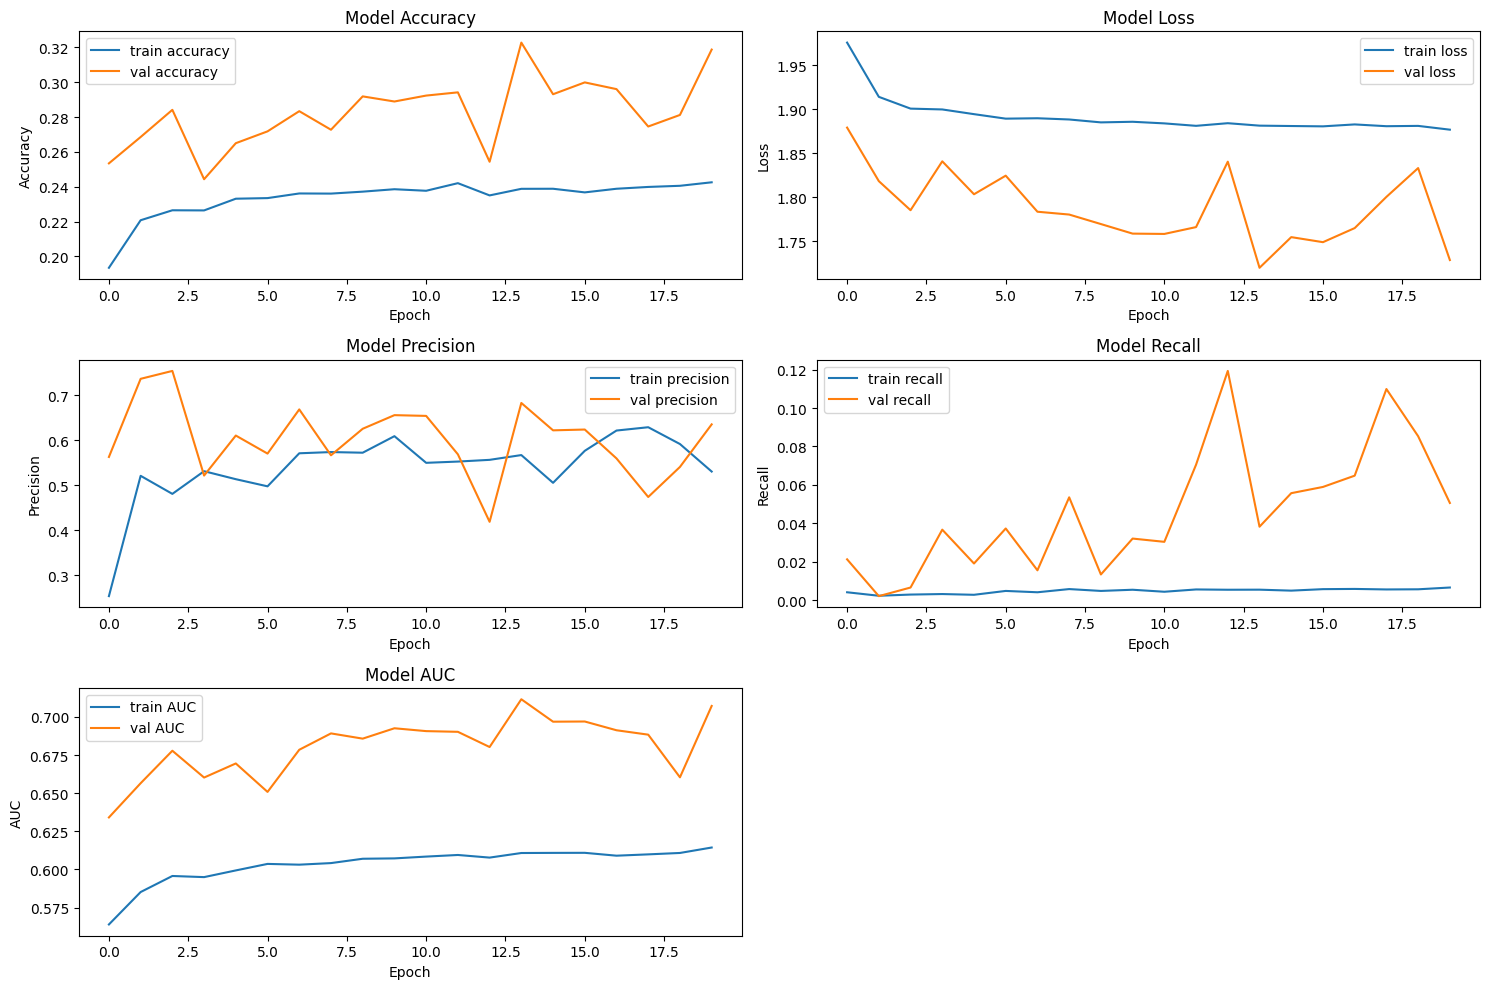

In [55]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


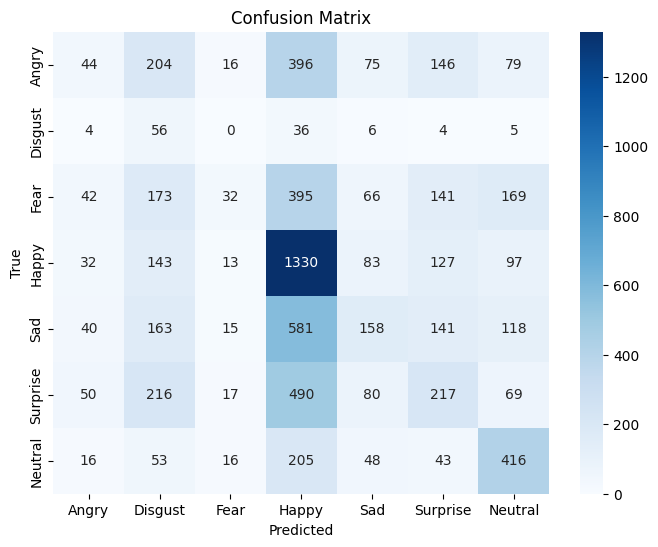

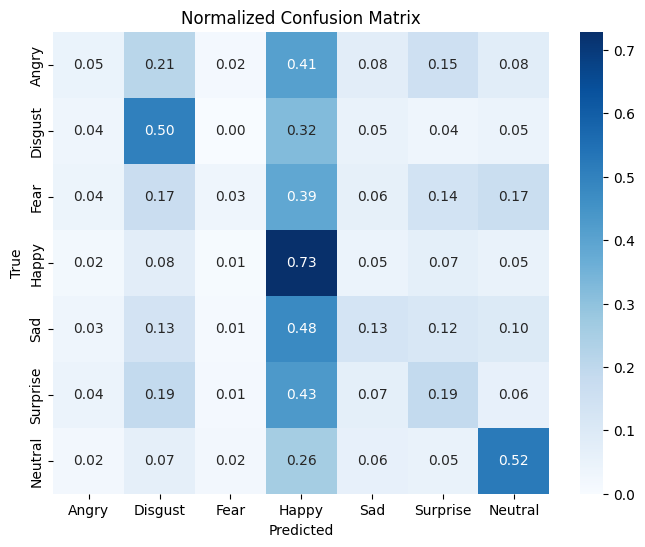

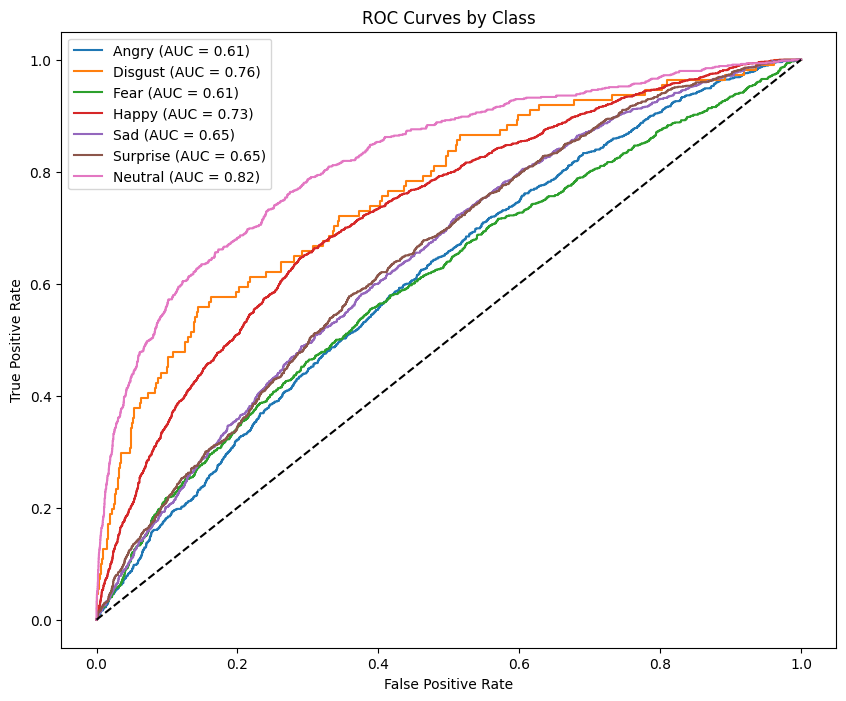

In [56]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




<h2 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;>FINE-TUNING VGGNET 19:</h2>
<h5>Radjen na poslednjem bloku</h5>

<h2 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">VGGNET19 FINE TUNING</h2>
<h4>Prikaz treniranja, vrijednosti izracunatih metrika, prikaz metrika na train i validation skupu, konfuziona matrica</h4>
Fine tuning pocev od block5_conv1, poboljsan makro F1

In [57]:
# Fine-tuning setup
fine_tune_epochs = 25  

fine_tune_at = 17  # block5_conv1

for layer in vgg_base.layers[:fine_tune_at]:
    layer.trainable = False

for layer in vgg_base.layers[fine_tune_at:]:
    # Otkljucam samo Conv2D i Dense slojeve
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
        layer.trainable = True
    else:
        layer.trainable = False
            

# Optimizer za fine-tuning (manji LR)
fine_tune_optimizer = optimizers.Adam(learning_rate=1e-4, amsgrad=True)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',
             metrics.Precision(name='precision'),
             metrics.Recall(name='recall'),
             metrics.AUC(name='auc')]
)

# Nastavi treniranje (fine-tune)
history_fine = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluacija nakon fine-tuninga
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# Predikcija i metrike
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)



Epoch 20/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 1916s 9s/step - accuracy: 0.2289 - auc: 0.5944 - loss: 1.9035 - precision: 0.5043 - recall: 0.0045 - val_accuracy: 0.2689 - val_auc: 0.6436 - val_loss: 1.8685 - val_precision: 0.6499 - val_recall: 0.0358 - learning_rate: 1.0000e-04
Epoch 21/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 1929s 10s/step - accuracy: 0.2487 - auc: 0.6178 - loss: 1.8677 - precision: 0.6145 - recall: 0.0085 - val_accuracy: 0.3275 - val_auc: 0.7116 - val_loss: 1.7609 - val_precision: 0.7987 - val_recall: 0.0190 - learning_rate: 1.0000e-04
Epoch 22/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 2018s 10s/step - accuracy: 0.2584 - auc: 0.6315 - loss: 1.8482 - precision: 0.6645 - recall: 0.0193 - val_accuracy: 0.2642 - val_auc: 0.6386 - val_loss: 1.8363 - val_precision: 0.6701 - val_recall: 0.0502 - learning_rate: 1.0000e-04
Epoch 23/105
203/203 ━━━━━━━━━━━━━━━━━━━━ 2006s 10s/step - accuracy: 0.2685 - auc: 0.6431 - loss: 1.8299 - precision: 0.6677 - recall: 0.0248 - val_accuracy: 0.3340 - val_auc: 

In [58]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("vgg19_finetune_full_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'vgg19_finetune_full_report.txt'")


Sve metrike i report su sačuvani u 'vgg19_finetune_full_report.txt'


In [59]:
with open("vgg19_finetune_full_report.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.1402033567428589, 0.5673648715019226, 0.7287555932998657, 0.3920181095600128, 0.8898312449455261]

=== Global metrics ===
Accuracy: 0.5674
Macro Precision: 0.5210
Weighted Precision: 0.5702
Macro Recall: 0.5515
Weighted Recall: 0.5674
Macro F1: 0.5205
Weighted F1: 0.5598
AUC (OVR): 0.8675

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4901    0.4115    0.4473       960
           1     0.3060    0.6396    0.4140       111
           2     0.4550    0.2583    0.3296      1018
           3     0.7850    0.8044    0.7946      1825
           4     0.4531    0.6637    0.5385      1216
           5     0.4521    0.4144    0.4324      1139
           6     0.7060    0.6688    0.6869       797

    accuracy                         0.5674      7066
   macro avg     0.5210    0.5515    0.5205      7066
weighted avg     0.5702    0.5674    0.5598      7066


In [61]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

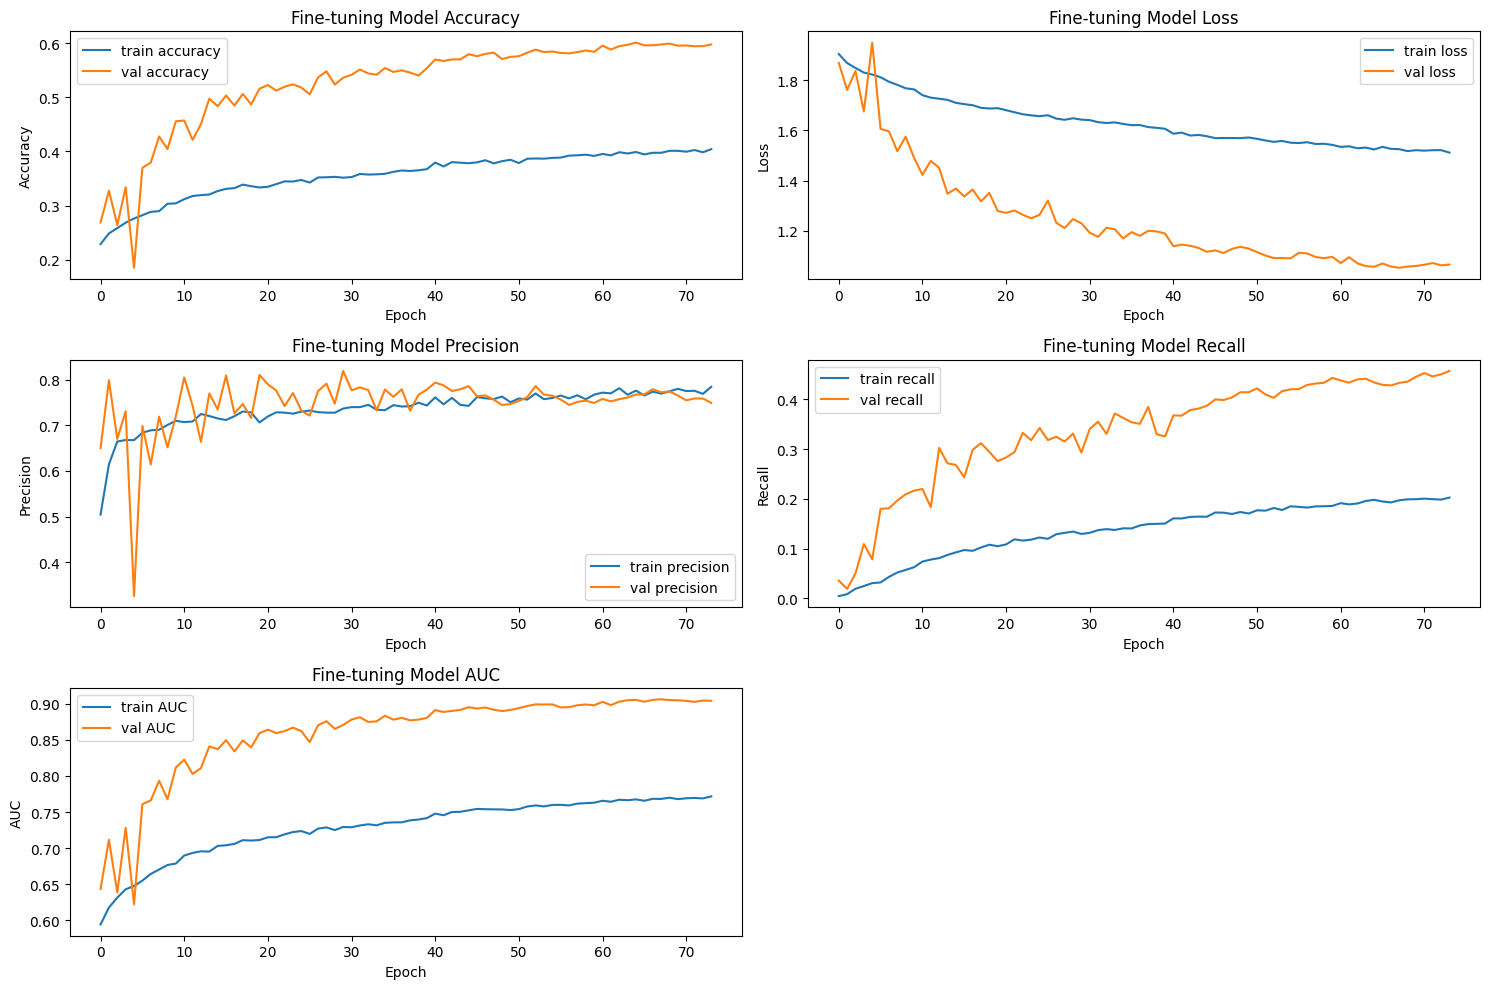

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.title('Fine-tuning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history_fine.history['precision'], label='train precision')
plt.plot(history_fine.history['val_precision'], label='val precision')
plt.title('Fine-tuning Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history_fine.history['recall'], label='train recall')
plt.plot(history_fine.history['val_recall'], label='val recall')
plt.title('Fine-tuning Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history_fine.history['auc'], label='train AUC')
plt.plot(history_fine.history['val_auc'], label='val AUC')
plt.title('Fine-tuning Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


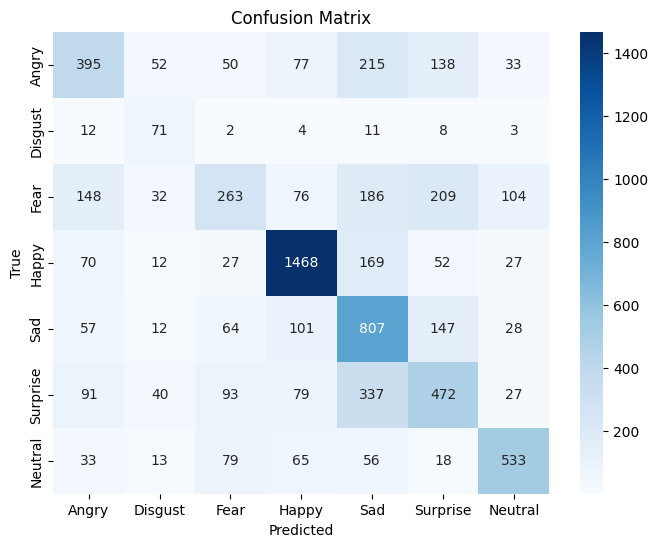

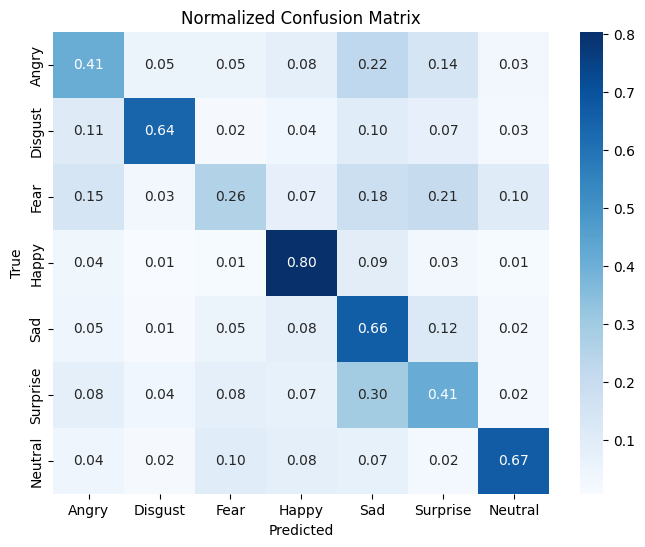

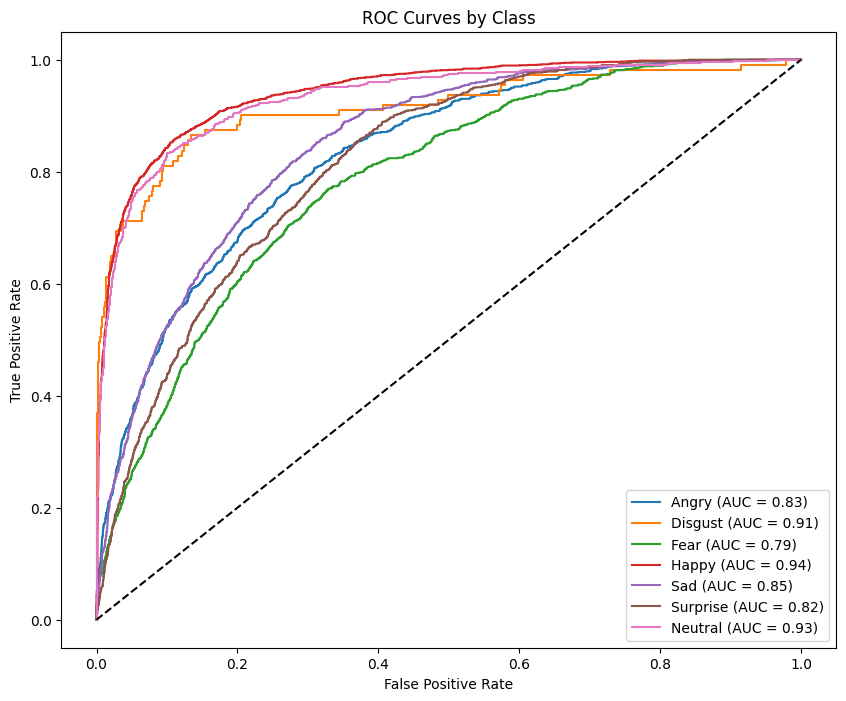

In [63]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [64]:
best_model.summary()


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 3, 3, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,609,630 (185.43 MB)

 Trainable params: 9,506,055 (36.26 MB)

 Non-trainable params: 10,585,408 (40.38 MB)

 Optimizer params: 28,518,167 (108.79 MB)

In [5]:
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
for i, layer in enumerate(best_model.get_layer("vgg19").layers):
    print(i, layer.name, layer.__class__.__name__, layer.trainable)

0 input_layer_19 InputLayer True
1 block1_conv1 Conv2D False
2 block1_conv2 Conv2D False
3 block1_pool MaxPooling2D False
4 block2_conv1 Conv2D False
5 block2_conv2 Conv2D False
6 block2_pool MaxPooling2D False
7 block3_conv1 Conv2D False
8 block3_conv2 Conv2D False
9 block3_conv3 Conv2D False
10 block3_conv4 Conv2D False
11 block3_pool MaxPooling2D False
12 block4_conv1 Conv2D False
13 block4_conv2 Conv2D False
14 block4_conv3 Conv2D False
15 block4_conv4 Conv2D False
16 block4_pool MaxPooling2D False
17 block5_conv1 Conv2D True
18 block5_conv2 Conv2D True
19 block5_conv3 Conv2D True
20 block5_conv4 Conv2D True
21 block5_pool MaxPooling2D False


<h2 style="color: #16537e; background-color: #ffcccc; padding: 10px; border-radius: 8px;">ADDITIONAL VGGNET19 FINE TUNING - prikaz samo za poredjenje</h2>
<h4>Prikaz treniranja, prikaz metrika na train i validation skupu</h4>
Fine tuning pocev od block4_conv4 nije popravio rezultate, sporo treniranje

In [23]:
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report

# Ucitavanje prethodno treniranog modela
best_model = tf.keras.models.load_model("best_vgg19_model.keras")

# Parametri
fine_tune_epochs = 15
batch_size = 128

# Postavljanje slojeva za fine-tuning
vgg = best_model.get_layer("vgg19")
fine_tune_at = 15  # block4_conv4

for layer in vgg.layers[:fine_tune_at]:
    layer.trainable = False
for layer in vgg.layers[fine_tune_at:]:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
        layer.trainable = True
    else:
        layer.trainable = False

fine_tune_optimizer = optimizers.Adam(learning_rate=5e-6, amsgrad=True)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)


best_model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

train_ds_rgb_1 = train_ds_rgb_1.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_rgb_1 = val_ds_rgb_1.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_rgb_1 = test_ds_rgb_1.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Fine-tuning
history_fine = best_model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=fine_tune_epochs,
    initial_epoch=0,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluacija
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# Predikcija i metrike
y_true = np.concatenate([y for x, y in test_ds_rgb_1], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0, target_names=train_class_names))
"""

Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 1956s 10s/step - accuracy: 0.3985 - auc: 0.7690 - loss: 1.5207 - precision: 0.7759 - recall: 0.1973 - val_accuracy: 0.6195 - val_auc: 0.9136 - val_loss: 1.0134 - val_precision: 0.7811 - val_recall: 0.4660 - learning_rate: 5.0000e-06
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 1904s 9s/step - accuracy: 0.4017 - auc: 0.7685 - loss: 1.5230 - precision: 0.7685 - recall: 0.1961 - val_accuracy: 0.6197 - val_auc: 0.9144 - val_loss: 1.0102 - val_precision: 0.7921 - val_recall: 0.4541 - learning_rate: 5.0000e-06
Epoch 3/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 1898s 9s/step - accuracy: 0.3987 - auc: 0.7676 - loss: 1.5263 - precision: 0.7711 - recall: 0.1966 - val_accuracy: 0.6202 - val_auc: 0.9152 - val_loss: 1.0058 - val_precision: 0.7950 - val_recall: 0.4586 - learning_rate: 5.0000e-06
Epoch 4/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 1975s 10s/step - accuracy: 0.4030 - auc: 0.7725 - loss: 1.5137 - precision: 0.7782 - recall: 0.2015 - val_accuracy: 0.6253 - val_auc: 0.9151 - 

NameError: name 'train_class_names' is not defined

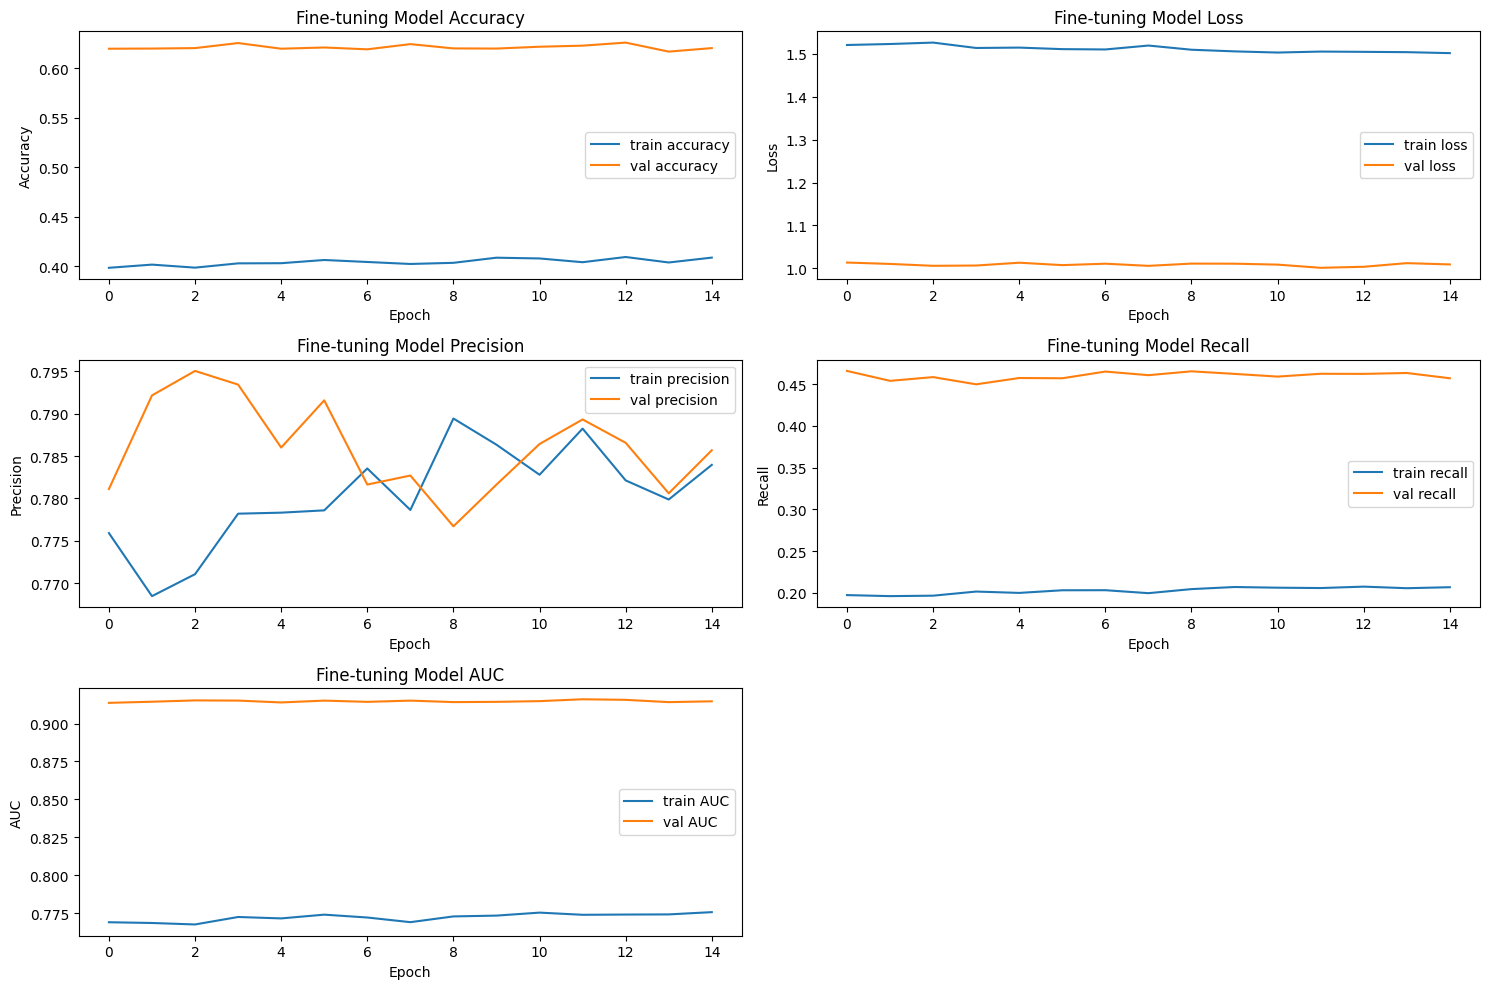

In [28]:
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history_fine.history['loss'], label='train loss')
plt.plot(history_fine.history['val_loss'], label='val loss')
plt.title('Fine-tuning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history_fine.history['accuracy'], label='train accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val accuracy')
plt.title('Fine-tuning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history_fine.history['precision'], label='train precision')
plt.plot(history_fine.history['val_precision'], label='val precision')
plt.title('Fine-tuning Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history_fine.history['recall'], label='train recall')
plt.plot(history_fine.history['val_recall'], label='val recall')
plt.title('Fine-tuning Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history_fine.history['auc'], label='train AUC')
plt.plot(history_fine.history['val_auc'], label='val AUC')
plt.title('Fine-tuning Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()
"""

<h1 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">INCEPTION V3 - NEW</h1> 
<h4>Prikaz treniranja, vrijednosti izracunatih metrika, prikaz metrika na train i validation skupu, konfuziona matrica</h4>
-model oko 3 puta brzi od VGGNET 19 -> veca dimenzija slika u odnosu na VGGNET 19
<br>
Model vise izmijenjen u odnosu na model u radu, radi mogucnosti poboljsanja konacnih rezultata <br>
Rezultati nedovoljno dobri, radi toga ce biti radjen fine tuning

In [10]:
train_ds_rgb_2 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
val_ds_rgb_2   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
test_ds_rgb_2  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))

In [11]:
for x, y in train_ds_rgb_2.take(1):
    print(x.shape) 

(128, 130, 130, 3)


Dimenzije slike: (48, 48, 3)


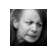

Dimenzije slike: (130, 130, 3)


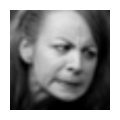

In [50]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_2.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_2)

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, f1_score

# Parametri
img_height = 130
img_width = 130
num_classes = 7
batch_size = 128
learning_rate = 5e-4 #u radu je 1e-3
epochs = 45

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.15)
])

# Build InceptionV3 model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in inception_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = inception_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_inception_model_new.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = load_model('best_inception_model_new.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/45
203/203 ━━━━━━━━━━━━━━━━━━━━ 644s 3s/step - accuracy: 0.2741 - auc: 0.6528 - loss: 1.9689 - precision: 0.3653 - recall: 0.0870 - val_accuracy: 0.3442 - val_auc: 0.7284 - val_loss: 1.7109 - val_precision: 0.5242 - val_recall: 0.0971 - learning_rate: 5.0000e-04
Epoch 2/45
203/203 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.3137 - auc: 0.6989 - loss: 1.7901 - precision: 0.4673 - recall: 0.0889 - val_accuracy: 0.3428 - val_auc: 0.7294 - val_loss: 1.7103 - val_precision: 0.5276 - val_recall: 0.1403 - learning_rate: 5.0000e-04
Epoch 3/45
203/203 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - accuracy: 0.3290 - auc: 0.7139 - loss: 1.7409 - precision: 0.5102 - recall: 0.0923 - val_accuracy: 0.3639 - val_auc: 0.7463 - val_loss: 1.6427 - val_precision: 0.6587 - val_recall: 0.0894 - learning_rate: 5.0000e-04
Epoch 4/45
203/203 ━━━━━━━━━━━━━━━━━━━━ 630s 3s/step - accuracy: 0.3369 - auc: 0.7203 - loss: 1.7194 - precision: 0.5361 - recall: 0.0901 - val_accuracy: 0.3775 - val_auc: 0.7544 - val_lo

In [42]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("inception_full_report_new.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'inception_full_report_new.txt'")


Sve metrike i report su sačuvani u 'inception_full_report_new.txt'


In [43]:
with open("inception_full_report_new.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.511175274848938, 0.42145484685897827, 0.6828660368919373, 0.1551089733839035, 0.7953670024871826]

=== Global metrics ===
Accuracy: 0.4215
Macro Precision: 0.3785
Weighted Precision: 0.4236
Macro Recall: 0.4011
Weighted Recall: 0.4215
Macro F1: 0.3534
Weighted F1: 0.4008
AUC (OVR): 0.7770

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.3755    0.1792    0.2426       960
           1     0.1044    0.5135    0.1735       111
           2     0.3867    0.1424    0.2082      1018
           3     0.5011    0.7370    0.5966      1825
           4     0.3859    0.4145    0.3997      1216
           5     0.3790    0.2941    0.3312      1139
           6     0.5166    0.5270    0.5217       797

    accuracy                         0.4215      7066
   macro avg     0.3785    0.4011    0.3534      7066
weighted avg     0.4236    0.4215    0.4008      7066


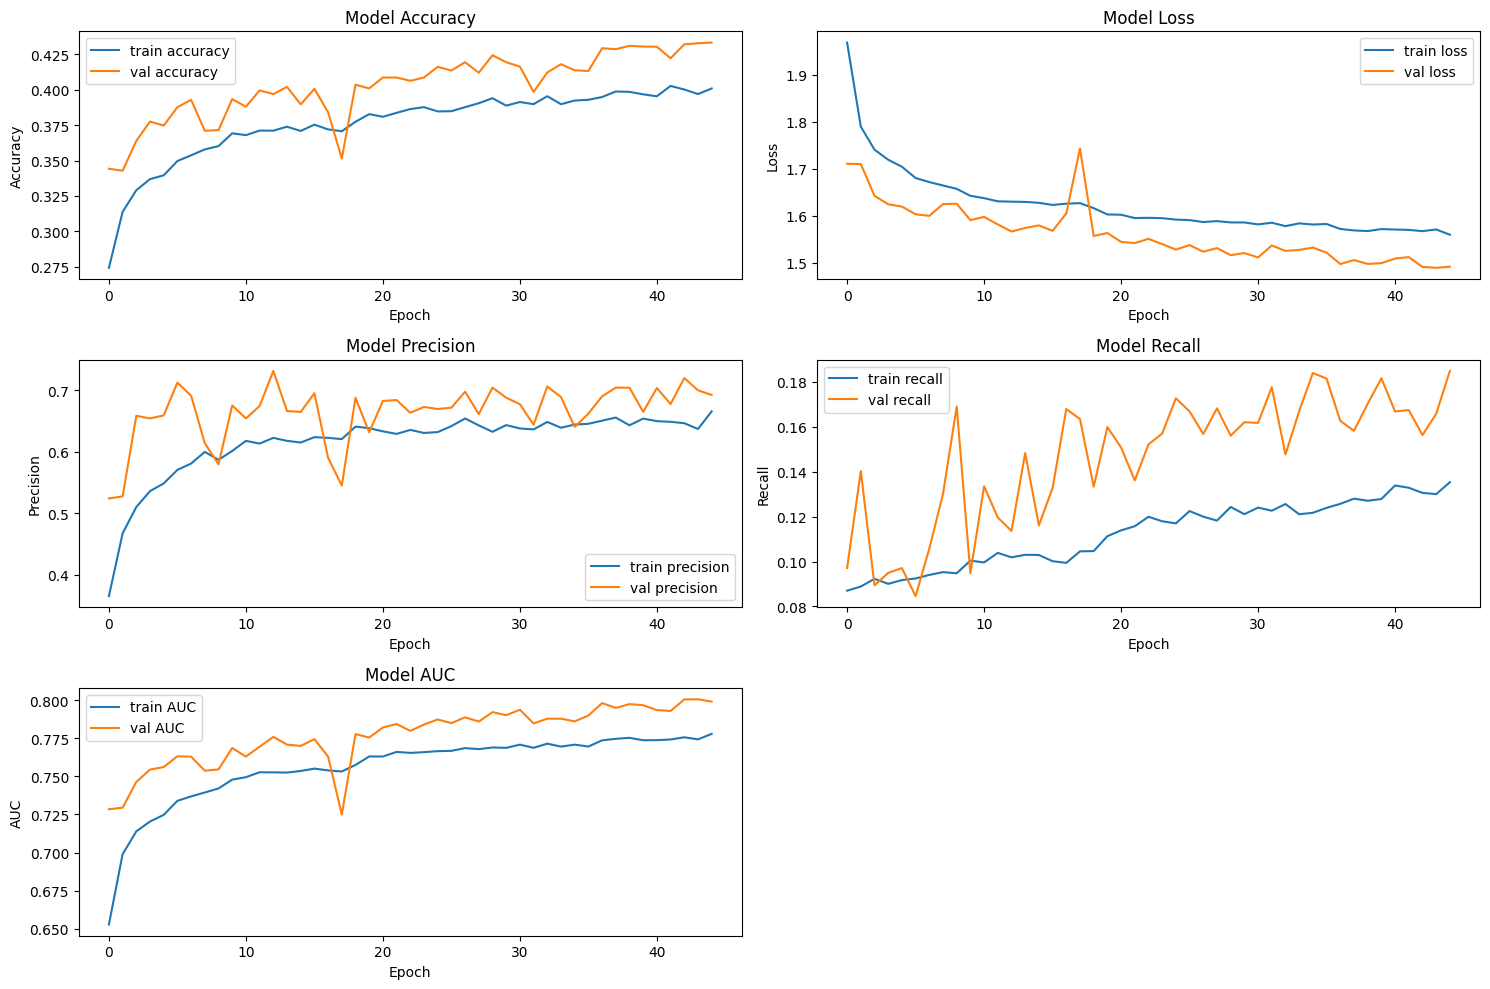

In [44]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


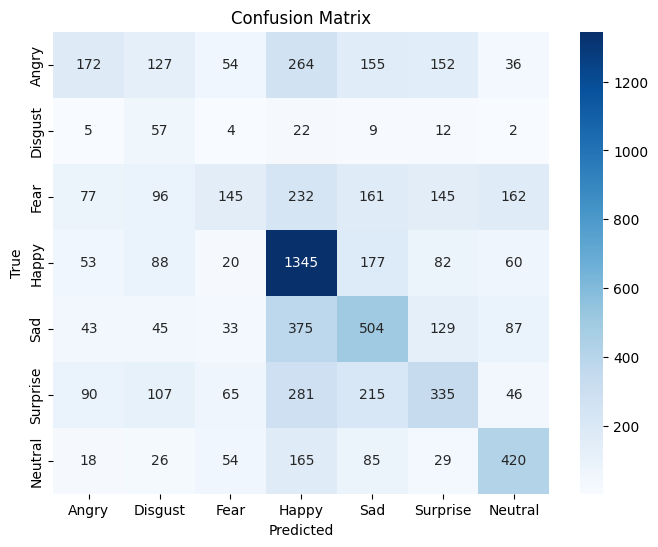

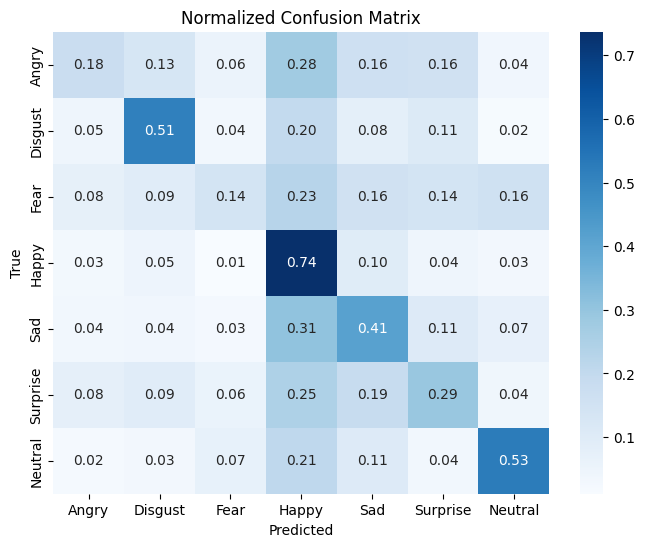

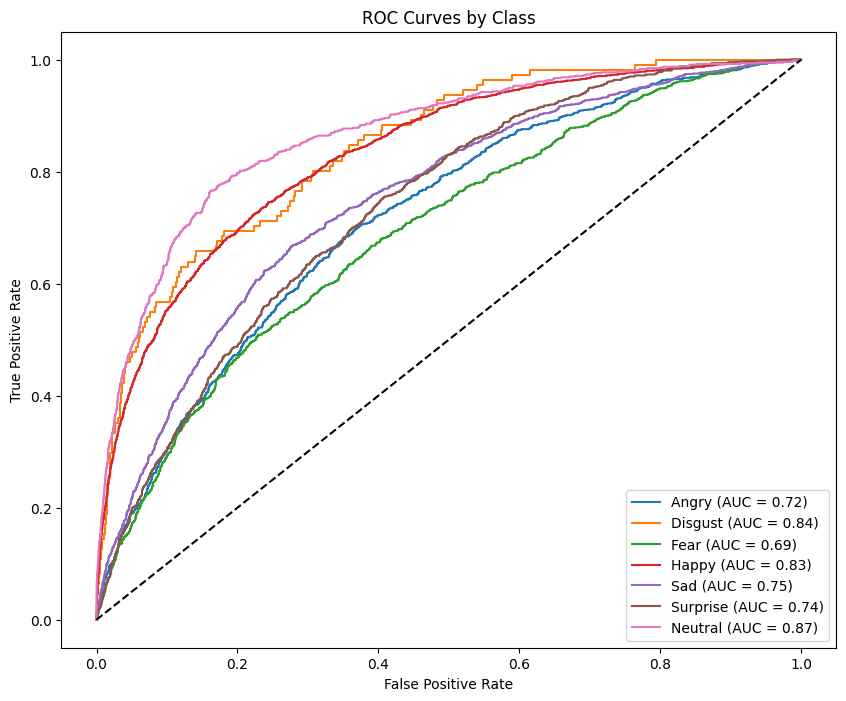

In [45]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

<h2 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">FINE-TUNING INCEPTION V3 - NEW:</h2>
<h4>Prikaz treniranja, vrijednosti izracunatih metrika, prikaz metrika na train i validation skupu, konfuziona matrica</h4>
Fine tuning pocev od conv2d_268 sloja (fin. block), poboljsan makro F1

In [58]:
best_model = load_model("best_inception_model_new.keras")

# Uzmem inception_v3 deo
inception_part = best_model.get_layer("inception_v3")

# Fine-tuning: 
fine_tune_at = 249

for layer in inception_part.layers[:fine_tune_at]:
    layer.trainable = False

for layer in inception_part.layers[fine_tune_at:]:
    if not isinstance(layer, (
        tf.keras.layers.BatchNormalization,
        tf.keras.layers.AveragePooling2D,
        tf.keras.layers.MaxPooling2D,
        tf.keras.layers.Concatenate
    )):
        layer.trainable = True
    else:
        layer.trainable = False

# Compile sa manjim learning rate
fine_tune_optimizer = optimizers.Adam(learning_rate=5e-5, amsgrad=True)

best_model.compile(
    optimizer=fine_tune_optimizer,
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        metrics.AUC(name="auc"),
    ]
)

# Nastavi treniranje
history_fine = best_model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=epochs,  # ako je prethodno bilo `epochs`
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)


# Evaluacija
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)


# Predikcija 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)


Epoch 46/78
203/203 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - accuracy: 0.4023 - auc: 0.7750 - loss: 1.5667 - precision: 0.6409 - recall: 0.1466 - val_accuracy: 0.4558 - val_auc: 0.8185 - val_loss: 1.4301 - val_precision: 0.7308 - val_recall: 0.2087 - learning_rate: 5.0000e-05
Epoch 47/78
203/203 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - accuracy: 0.4274 - auc: 0.7965 - loss: 1.5025 - precision: 0.6633 - recall: 0.1839 - val_accuracy: 0.4789 - val_auc: 0.8298 - val_loss: 1.3874 - val_precision: 0.7198 - val_recall: 0.2502 - learning_rate: 5.0000e-05
Epoch 48/78
203/203 ━━━━━━━━━━━━━━━━━━━━ 726s 3s/step - accuracy: 0.4515 - auc: 0.8110 - loss: 1.4560 - precision: 0.6856 - recall: 0.2038 - val_accuracy: 0.4800 - val_auc: 0.8318 - val_loss: 1.3829 - val_precision: 0.6738 - val_recall: 0.2857 - learning_rate: 5.0000e-05
Epoch 49/78
203/203 ━━━━━━━━━━━━━━━━━━━━ 714s 4s/step - accuracy: 0.4593 - auc: 0.8200 - loss: 1.4265 - precision: 0.6926 - recall: 0.2211 - val_accuracy: 0.4954 - val_auc: 0.8445 - va

In [61]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from tensorflow.keras.models import load_model

# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class 
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

#  Save everything to file 
with open("inception_finetune_full_report_new.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'inception_full_report_new.txt'")

Sve metrike i report su sačuvani u 'inception_full_report_new.txt'


In [62]:
with open("inception_finetune_full_report_new.txt", "r") as f:
    report_content = f.read()

print(report_content)


=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.1928571462631226, 0.550382137298584, 0.6909090876579285, 0.4033399522304535, 0.8800258040428162]

=== Global metrics ===
Accuracy: 0.5504
Macro Precision: 0.5317
Weighted Precision: 0.5457
Macro Recall: 0.5458
Weighted Recall: 0.5504
Macro F1: 0.5340
Weighted F1: 0.5436
AUC (OVR): 0.8571

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4203    0.4260    0.4232       960
           1     0.5639    0.6757    0.6148       111
           2     0.4336    0.2662    0.3299      1018
           3     0.7397    0.7600    0.7497      1825
           4     0.4655    0.5938    0.5219      1216
           5     0.4581    0.4363    0.4469      1139
           6     0.6408    0.6625    0.6514       797

    accuracy                         0.5504      7066
   macro avg     0.5317    0.5458    0.5340      7066
weighted avg     0.5457    0.5504    0.5436      7066



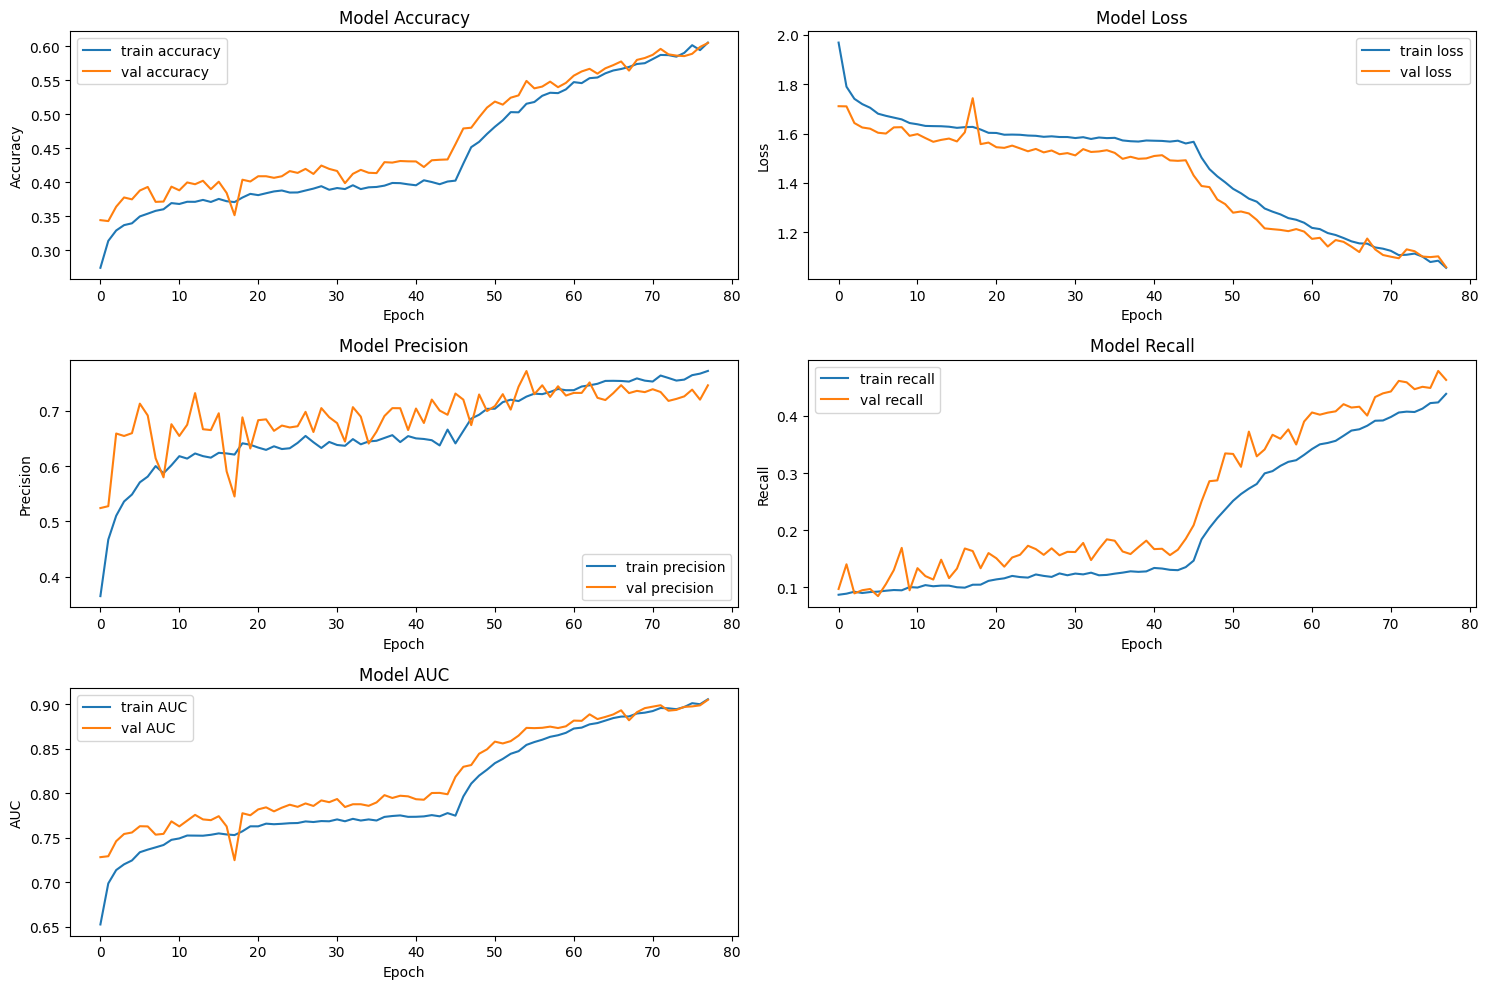

In [63]:
# Za sve epohe do sada spojeni prikaz
def combine_history(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

combined_history = combine_history(history, history_fine)

plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(combined_history['loss'], label='train loss')
plt.plot(combined_history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(combined_history['accuracy'], label='train accuracy')
plt.plot(combined_history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(combined_history['precision'], label='train precision')
plt.plot(combined_history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(combined_history['recall'], label='train recall')
plt.plot(combined_history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(combined_history['auc'], label='train AUC')
plt.plot(combined_history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


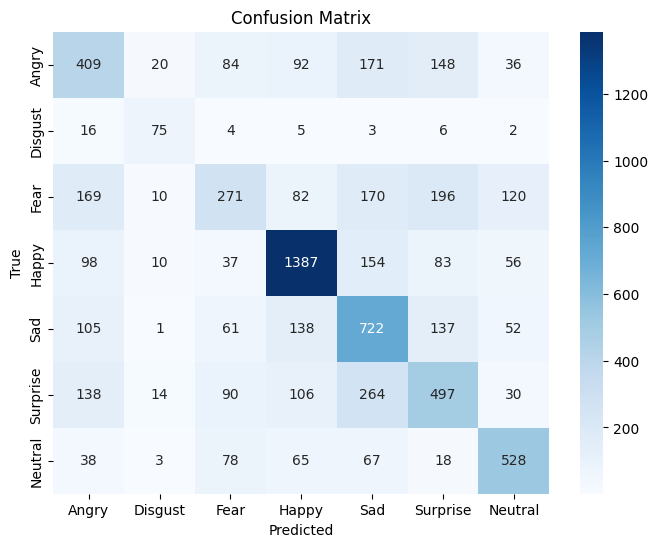

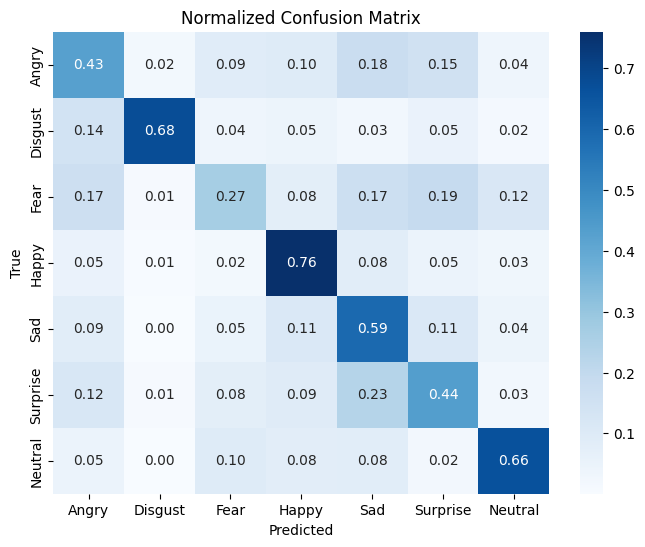

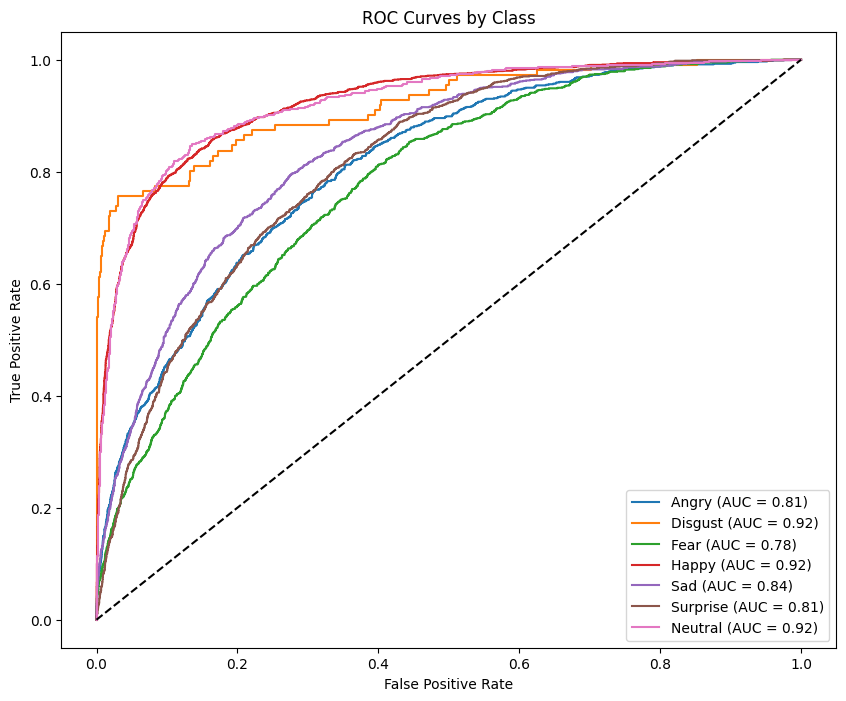

In [64]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [65]:
best_model.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_284              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,181,822 (214.32 MB)

 Trainable params: 11,371,783 (43.38 MB)

 Non-trainable params: 10,694,688 (40.80 MB)

 Optimizer params: 34,115,351 (130.14 MB)

In [66]:
from tensorflow.keras.models import load_model
best_model = load_model('best_inception_model_new.keras')

for i, layer in enumerate(best_model.layers[2].layers):  # [2] jer inception_v3 је treci sloj u modelu
    print(i, layer.name, layer.trainable)


0 input_layer_6 True
1 conv2d_188 False
2 batch_normalization_190 False
3 activation_188 False
4 conv2d_189 False
5 batch_normalization_191 False
6 activation_189 False
7 conv2d_190 False
8 batch_normalization_192 False
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_191 False
12 batch_normalization_193 False
13 activation_191 False
14 conv2d_192 False
15 batch_normalization_194 False
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_196 False
19 batch_normalization_198 False
20 activation_196 False
21 conv2d_194 False
22 conv2d_197 False
23 batch_normalization_196 False
24 batch_normalization_199 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_193 False
29 conv2d_195 False
30 conv2d_198 False
31 conv2d_199 False
32 batch_normalization_195 False
33 batch_normalization_197 False
34 batch_normalization_200 False
35 batch_normalization_201 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activ

<div style="background-color: #cceeff; padding: 10px; border-radius: 8px;">
  <p>Zakljucak za oba modela - emocija 'Fear' ima najslabiji recall, model cesto pogresno detektuje emocije 'Fear', 'Surprise', i 'Angry' radi slicnih karakteristika lica. Tehnike koje su primijenjene da bi se ovaj problem regulisao u odredjenoj mjeri jesu - <b>fine tuning, additional fine tuning, class weighting, strong augmentation </b> za pomenute klase <b>sa oversamplingom</b></p>
</div>


<h1 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">BASELINE CNN:</h1>
<h4>Prikaz treniranja, vrijednosti izracunatih metrika, prikaz metrika na train i validation skupu, konfuziona matrica</h4>
Napravljen model za slika sa 1 i 3 kanala <br>
Ulazne slike dimenzija 48x48

<h2 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">RGB:</h2>

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report

img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 5e-4
epochs = 100

train_class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, model_checkpoint, lr_scheduler]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 74s 325ms/step - accuracy: 0.2458 - auc: 0.6199 - loss: 1.8985 - precision: 0.2696 - recall: 0.0061 - val_accuracy: 0.2212 - val_auc: 0.6308 - val_loss: 1.8867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - accuracy: 0.3206 - auc: 0.6993 - loss: 1.7498 - precision: 0.6153 - recall: 0.0395 - val_accuracy: 0.3102 - val_auc: 0.7199 - val_loss: 1.7818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 81s 315ms/step - accuracy: 0.3630 - auc: 0.7405 - loss: 1.6566 - precision: 0.6651 - recall: 0.0925 - val_accuracy: 0.4331 - val_auc: 0.7984 - val_loss: 1.5507 - val_precision: 0.8650 - val_recall: 0.0871 - learning_rate: 5.0000e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step - accuracy: 0.4028 - auc: 0.7706 - loss: 1.5786 - precision: 0.6909 - recall: 0.1382 - val_accuracy: 0.437

In [34]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("baseline_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'baseline_report.txt'")

Sve metrike i report su sačuvani u 'baseline_report.txt'


In [35]:
with open("baseline_report.txt", "r") as f:
    report_content = f.read()

print(report_content)

=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.0234706401824951, 0.6147750020027161, 0.7587628960609436, 0.46872347593307495, 0.9124701023101807]

=== Global metrics ===
Accuracy: 0.6148
Macro Precision: 0.5768
Weighted Precision: 0.6120
Macro Recall: 0.6061
Weighted Recall: 0.6148
Macro F1: 0.5853
Weighted F1: 0.6103
AUC (OVR): 0.8932

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.5076    0.4885    0.4979       960
           1     0.4706    0.7207    0.5694       111
           2     0.4773    0.3517    0.4050      1018
           3     0.8282    0.8455    0.8368      1825
           4     0.5199    0.6431    0.5750      1216
           5     0.5019    0.4706    0.4857      1139
           6     0.7319    0.7227    0.7273       797

    accuracy                         0.6148      7066
   macro avg     0.5768    0.6061    0.5853      7066
weighted avg     0.6120    0.6148    0.6103      7066

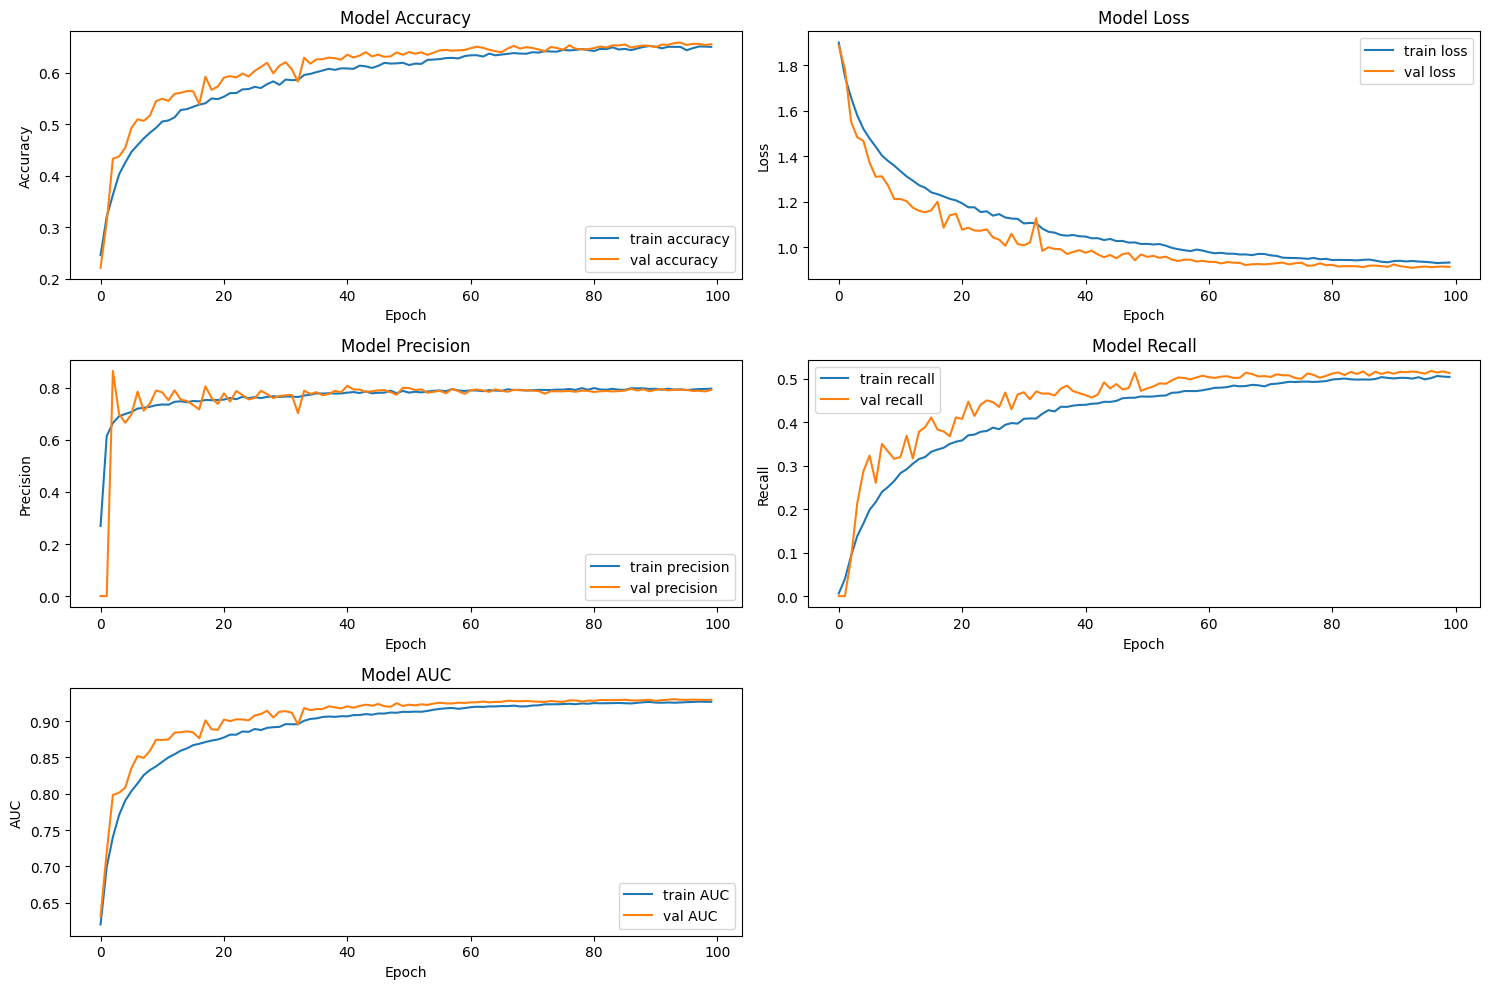

In [37]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

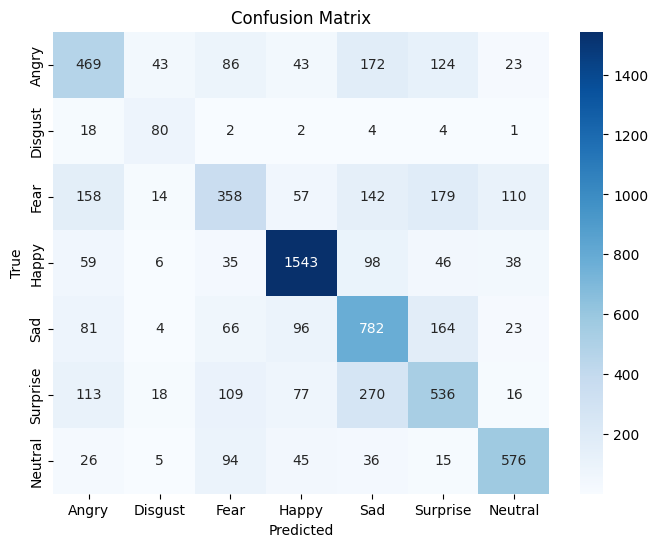

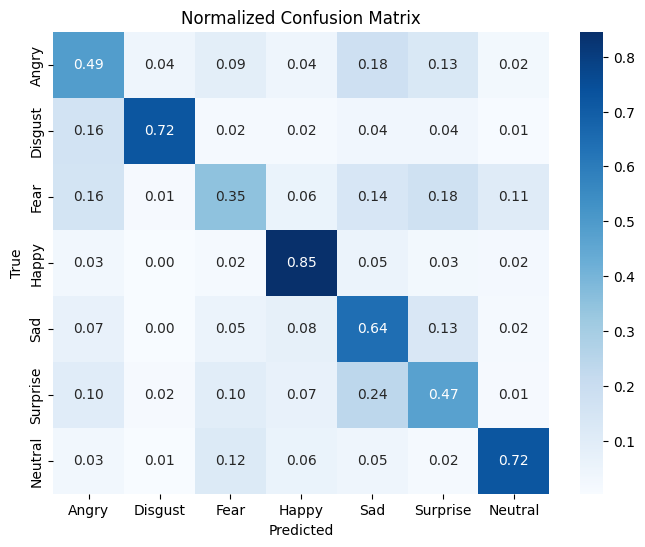

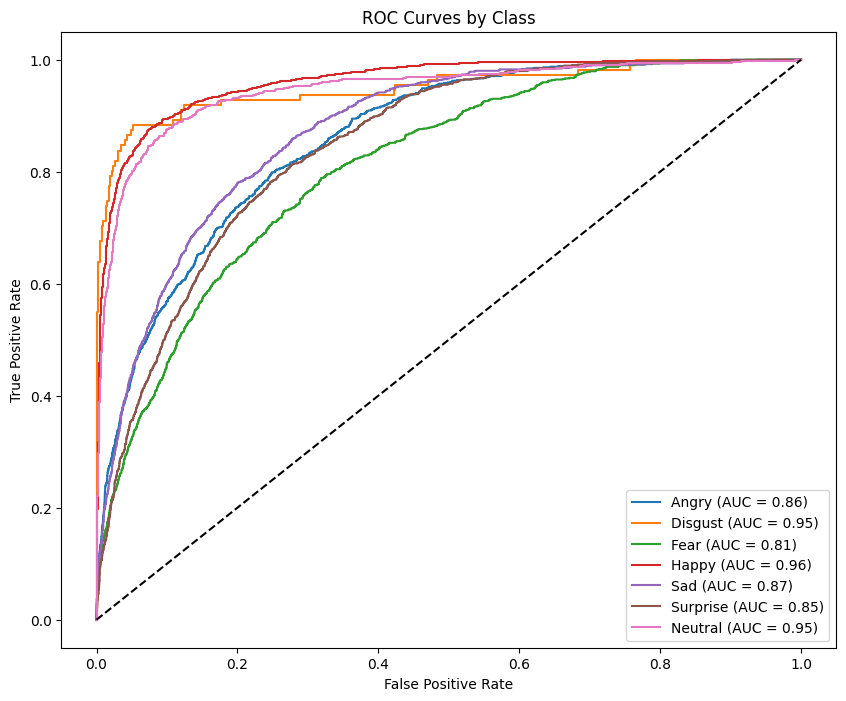

In [38]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.models import load_model
best_model = load_model('best_baseline_cnn.keras')
best_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,053,335 (7.83 MB)

 Trainable params: 684,359 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,368,720 (5.22 MB)

<h2 style="color: #16537e; background-color: #ccffcc; padding: 10px; border-radius: 8px;">GRAYSCALE:</h2>

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, classification_report

img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 5e-4
epochs = 100

train_class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def to_grayscale(image, label):
    # iz [48,48,3] u [48,48,1]
    image = tf.image.rgb_to_grayscale(image)
    return image, label

# Konverzija za train/val/test skupove
train_ds_gray = train_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_gray = val_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gray = test_ds_rgb.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2)
])

# Build baseline CNN za grayscale
inputs = layers.Input(shape=(img_height, img_width, 1))   # grayscale
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn_gray.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train
history = model.fit(
    train_ds_gray,   
    validation_data=val_ds_gray,
    epochs=epochs,
    callbacks=[early_stop, model_checkpoint, lr_scheduler]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn_gray.keras')
eval_results = best_model.evaluate(test_ds_gray)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_gray], axis=0)
y_pred_prob = best_model.predict(test_ds_gray)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0, target_names=train_class_names))


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 66s 287ms/step - accuracy: 0.2342 - auc: 0.6158 - loss: 1.8936 - precision: 0.2284 - recall: 0.0020 - val_accuracy: 0.2212 - val_auc: 0.6232 - val_loss: 1.8914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.3088 - auc: 0.6910 - loss: 1.7669 - precision: 0.6028 - recall: 0.0303 - val_accuracy: 0.2846 - val_auc: 0.7087 - val_loss: 1.8040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 87s 274ms/step - accuracy: 0.3612 - auc: 0.7378 - loss: 1.6637 - precision: 0.6645 - recall: 0.0894 - val_accuracy: 0.4127 - val_auc: 0.7808 - val_loss: 1.5827 - val_precision: 0.8238 - val_recall: 0.0866 - learning_rate: 5.0000e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.4011 - auc: 0.7694 - loss: 1.5806 - precision: 0.6869 - recall: 0.1356 - val_accuracy: 0.456

In [41]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import numpy as np
# Macro and Weighted metrics
macro_f1 = f1_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_precision = precision_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_precision = precision_score(y_true_classes, y_pred, average='weighted', zero_division=0)
macro_recall = recall_score(y_true_classes, y_pred, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true_classes, y_pred)
auc_global = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')

# Classification report per class
class_report = classification_report(y_true_classes, y_pred, digits=4, zero_division=0)

# Save everything to file
with open("baseline_gray_report.txt", "w") as f:
    f.write("=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===\n")
    f.write(str(eval_results) + "\n\n")
    
    f.write("=== Global metrics ===\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Macro Precision: {macro_precision:.4f}\n")
    f.write(f"Weighted Precision: {weighted_precision:.4f}\n")
    f.write(f"Macro Recall: {macro_recall:.4f}\n")
    f.write(f"Weighted Recall: {weighted_recall:.4f}\n")
    f.write(f"Macro F1: {macro_f1:.4f}\n")
    f.write(f"Weighted F1: {weighted_f1:.4f}\n")
    f.write(f"AUC (OVR): {auc_global:.4f}\n\n")
    
    f.write("=== Per-class metrics ===\n")
    f.write(class_report)

print("Sve metrike i report su sačuvani u 'baseline_gray_report.txt'")

Sve metrike i report su sačuvani u 'baseline_gray_report.txt'


In [42]:
with open("baseline_gray_report.txt", "r") as f:
    report_content = f.read()

print(report_content)

=== Eval results (from model.evaluate - loss, accuracy, precision, recall, AUC) ===
[1.029132604598999, 0.6164732575416565, 0.7502252459526062, 0.47141239047050476, 0.91164630651474]

=== Global metrics ===
Accuracy: 0.6165
Macro Precision: 0.5984
Weighted Precision: 0.6175
Macro Recall: 0.6082
Weighted Recall: 0.6165
Macro F1: 0.6000
Weighted F1: 0.6140
AUC (OVR): 0.8917

=== Per-class metrics ===
              precision    recall  f1-score   support

           0     0.4995    0.5115    0.5054       960
           1     0.6031    0.7117    0.6529       111
           2     0.4867    0.3585    0.4129      1018
           3     0.8425    0.8323    0.8374      1825
           4     0.5045    0.6447    0.5661      1216
           5     0.5037    0.4759    0.4894      1139
           6     0.7490    0.7227    0.7356       797

    accuracy                         0.6165      7066
   macro avg     0.5984    0.6082    0.6000      7066
weighted avg     0.6175    0.6165    0.6140      7066



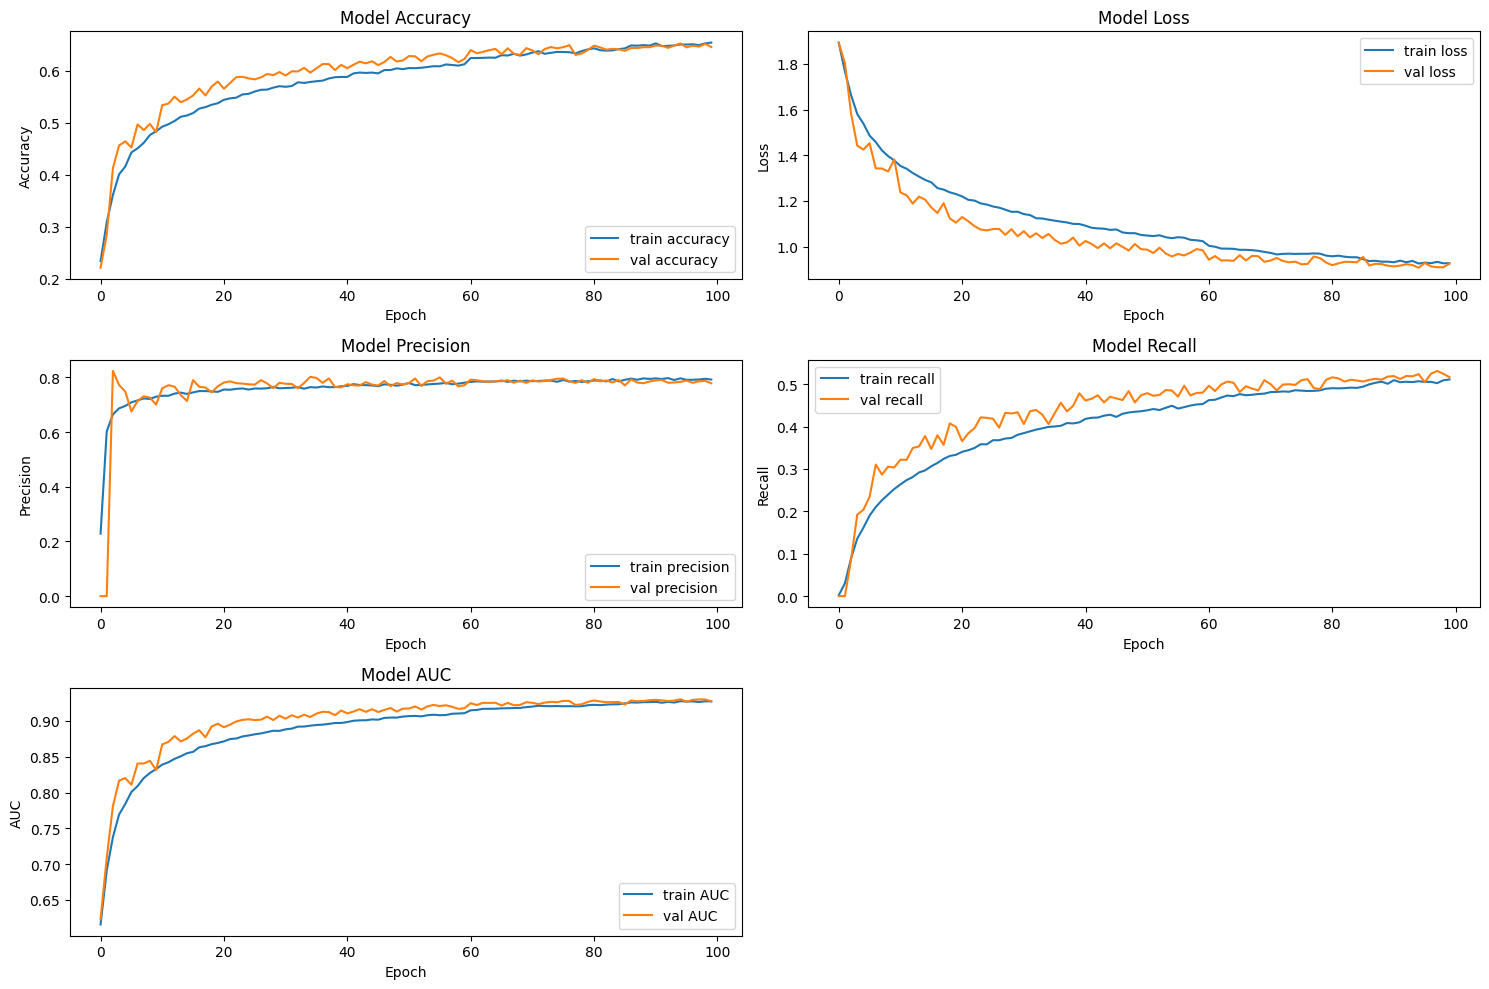

In [44]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()

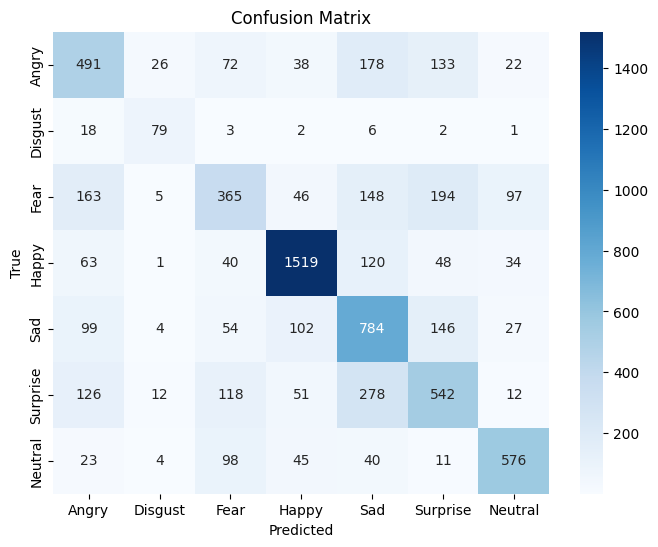

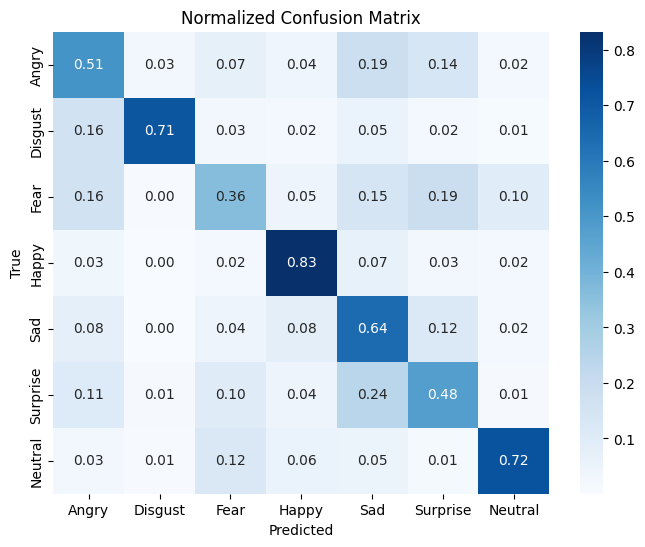

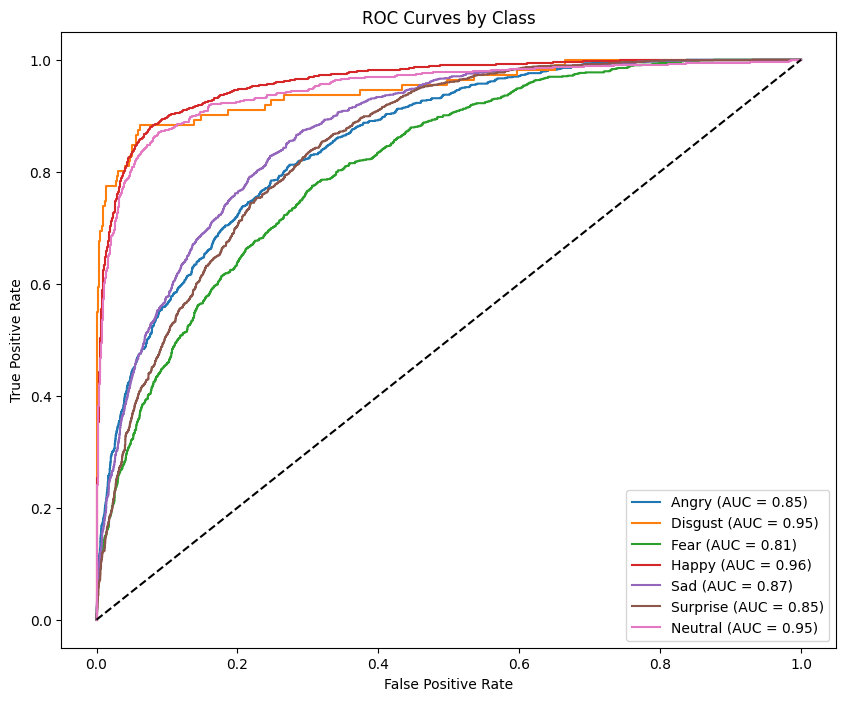

In [45]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()

In [46]:
from tensorflow.keras.models import load_model
best_model = load_model('best_baseline_cnn_gray.keras')
best_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,051,607 (7.83 MB)

 Trainable params: 683,783 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 1,367,568 (5.22 MB)

<div style="background-color: #cceeff; padding: 10px; border-radius: 8px;">
  <p>Baseline CNN model je postigao najbolji makro F1 skor, i to u varijanti koja radi na grayscale slikama. Razlog za ovakav rezultat može biti u tome što uklanjanje boje smanjuje kompleksnost ulaza i eliminiše šum, pa se model fokusira na strukturne i teksturalne karakteristike koje su ključne za klasifikaciju. Dodatno, jednostavnija arhitektura poput baznog CNN-a može biti bolje prilagođena konkretnom skupu podataka nego duboke mreže, koje imaju mnogo više parametara i teže se prilagođavaju kada nema dovoljno raznovrsnih ili velikih podataka za učenje.</p>
</div>
